In [1]:
import sys
sys.path.insert(1, './env')
sys.path.insert(1, './agents')

import gym
import pylab
import random
import aa_gun
import strategy_imitation, sarsa
import numpy as np
from collections import deque
import keras
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

EPISODES = 30000

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 160)               2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 160)               640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 160)               25760     
_________________________________________________________________
batch_normalization_2 (Batch (None, 160)               640       
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0         
_______________________

Epoch 1/1
4750/4750 [==============================] - 0s 5us/step - loss: 0.0500
Epoch 1/1
4750/4750 [==============================] - 0s 5us/step - loss: 0.0241
episode: 18   score: 0.5625   memory length: 4750   epsilon: 0.009998671593271896
Epoch 1/1
5000/5000 [==============================] - 0s 5us/step - loss: 0.0458
Epoch 1/1
5000/5000 [==============================] - 0s 5us/step - loss: 0.0237
episode: 19   score: 0   memory length: 5000   epsilon: 0.009998671593271896
Epoch 1/1
5250/5250 [==============================] - 0s 8us/step - loss: 0.0508
Epoch 1/1
5250/5250 [==============================] - 0s 5us/step - loss: 0.0296
episode: 20   score: 0.0625   memory length: 5250   epsilon: 0.009998671593271896
Epoch 1/1
5500/5500 [==============================] - 0s 5us/step - loss: 0.0517
Epoch 1/1
5500/5500 [==============================] - 0s 5us/step - loss: 0.0332
episode: 21   score: 0   memory length: 5500   epsilon: 0.009998671593271896
hit
Epoch 1/1
5750/5750 [=

KeyboardInterrupt: 

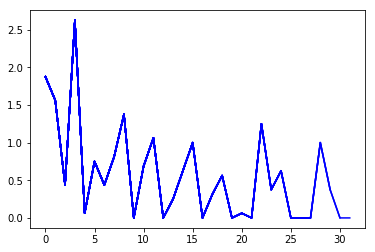

In [2]:
# In case of CartPole-v1, maximum length of episode is 500
env = aa_gun.AA_gun_simple0_env()
#env=CartPoleEnv9()
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#agent = DoubleDQNAgent(state_size, action_size)
agent = sarsa.SarsaAgent(state_size, action_size)
#agent = strategy_imitation.ImitAgent(state_size, action_size)
agent.render=False

scores, episodes = [], []
reward_lst = []
s_list=[]
a_list=[]

for e in range(EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:
        if (e in range(2,7)) or (e in range(20,25)) or (e in range(100,103)) or (e in range(200,202)) or (e in range(300,306)) or (e in range(400,406)) or (e in range(500,506)) or (e in range(600,604)):
            if agent.render:
                env.render()

        # get action for the current state and go one step in environment
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
        

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, done)
        #if next_state[0,11]!=reward:
        #    print('state[13]!=reward',state[0,11],reward)
        #
        s_list.append(state)
        a_list.append(action)
        reward_lst.append(reward)
        #
        
        # every time step do the training
        agent.train_model()
        score += reward
        state = next_state

        if done:
            # every episode update the target model to be same with model
            agent.update_target_model()

            # every episode, plot the play time
            scores.append(score)
            episodes.append(e)
            pylab.plot(episodes, scores, 'b')
            #pylab.savefig("./save_graph/aa_gun_dqn.png")
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon)

            # if the mean of scores of last 10 episode is bigger than 490
            # stop training

    # save the model
    #if e % 50 == 0:
    #    agent.model.save_weights("./save_model/aa_gun_dqn.h5")

In [3]:
def make_sar_table(s,a,r):
    #print(np.array(a,ndmin=2).T.shape)
    #print(np.array(r,ndmin=2).T.shape)
    #print(np.array(s,ndmin=2)[:,0,:].shape)
    return np.hstack( (np.array(s,ndmin=2)[:,0,:],np.array(a,ndmin=2).T,np.array(r,ndmin=2).T) )

0.0022453703703703702


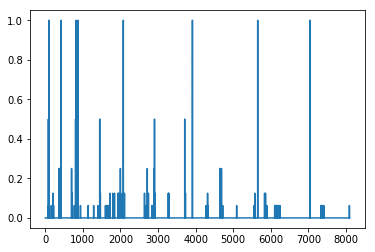

In [4]:
import matplotlib.pyplot as plt
print(np.mean(reward_lst))
plt.plot(reward_lst)

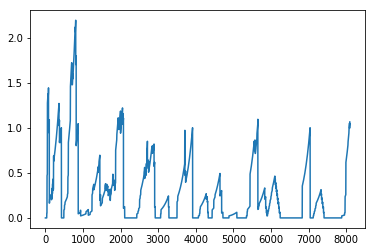

In [5]:
plt.plot(agent.r_disco)

In [8]:
np.mean(reward_lst)

0.0022839283567736507

In [9]:
#Чтобы анализировать разрешимость задачи
def replicate_reward(sar,border=0,wanted_part=0.5):
    part = np.mean(sar[:,-1:]>border)
    if part==0:
        print('ERROR')
        return(sar)
    else:
        while part<wanted_part:
            sar=np.vstack((sar,sar[np.where(sar[:,-1:]>border)[0],:]))
            part = np.mean(sar[:,-1:]>border)
        print(part)
        return(sar)

In [ ]:
sar=make_sar_table(s_list,a_list,reward_lst)
sar=replicate_reward(sar)
X=sar[1:,:]
Y=sar[:-1,:]
Y=sar[:-1,-1:]
Y=sar[1:,-1:]
sar_width=X.shape[1]
nn = Sequential()
nn.add(Dense(200, input_dim=sar_width, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(BatchNormalization())
nn.add(Dropout(0.2))
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
nn.add(Dense(200, activation='relu',
                kernel_initializer='he_uniform',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dropout(0.2))
nn.add(BatchNormalization())
#nn.add(Dense(sar_width, activation='linear',
#                kernel_initializer='he_uniform'))
nn.add(Dense(1, activation='linear',
                kernel_initializer='he_uniform'))

nn.summary()
nn.compile(loss='mse', optimizer=Adam(lr=0.001))
l=X.shape[0]
X_train=X[:int(l/2),:]
Y_train=Y[:int(l/2),:]
X_test=X[int(l/2):,:]
Y_test=Y[int(l/2):,:]
nn.fit(X_train, Y_train, batch_size=1200,epochs=30000, verbose=1)

In [ ]:
Y_pred=np.array(nn.predict(X_test),ndmin=2)
mse = np.mean((Y_pred-Y_test)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_test))/np.mean(np.abs(Y_test))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_test),axis=0)/np.mean(np.abs(Y_test),axis=0)
print(rmae_diversed)

In [ ]:
colnumn_num=-1
plt.plot(Y_pred[:3000,colnumn_num])
plt.plot(Y_test[:3000,colnumn_num])
plt.show()

In [ ]:
#train (переобучение?)
Y_pred=np.array(nn.predict(X_train),ndmin=2)
mse = np.mean((Y_pred-Y_train)**2)
print(mse)
rmae=np.mean(np.abs(Y_pred-Y_train))/np.mean(np.abs(Y_train))
print(rmae)
rmae_diversed=np.mean(np.abs(Y_pred-Y_train),axis=0)/np.mean(np.abs(Y_train),axis=0)
print(rmae_diversed)

colnumn_num=-1
plt.plot(Y_pred[:1300,colnumn_num])
plt.plot(Y_train[:1300,colnumn_num])
plt.show()

In [ ]:
import xgboost as xgb
xgbparams = {
    'booster':'gbtree',
    'metric':'mse',
    'objective':'reg:squarederror',
    'verbosity':0,
    'max_depth': 7,
    'n_estimators': 90,
    'eta': 0.3,
    'nthreads': 2,
    'seed':0
}
nn=xgb.XGBRegressor(**xgbparams)
nn.fit(X_train[:int(l/4),:], Y_train[:int(l/4),:],
           eval_set=[(X_train[int(l/4):,:], Y_train[int(l/4):,:])],
           verbose=True)

In [ ]:
import pandas as pd
df=pd.DataFrame(sar)
df[df[13]>0]